<a href="https://colab.research.google.com/github/Bhawana874/Blockhouse-impact-model/blob/main/QuantitativeAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install cvxpy --quiet


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp


In [3]:
ask_prices = np.array([80.97, 80.99, 81.00])
ask_sizes = np.array([110, 123, 140])
mid_price = (80.93 + 80.97) / 2

In [5]:
def compute_slippage(x, prices, sizes, mid):
    total_cost = 0
    remaining = x
    for price, size in zip(prices, sizes):
        if remaining <= 0:
            break
        take = min(remaining, size)
        total_cost += take * price
        remaining -= take
    if remaining > 0:
        return np.nan
    avg_price = total_cost / x
    return avg_price - mid


In [6]:
order_sizes = np.arange(10, 400, 10)
slippages = []

for x in order_sizes:
    slip = compute_slippage(x, ask_prices, ask_sizes, mid_price)
    slippages.append(slip)

# Filter valid points
valid_idx = ~np.isnan(slippages)
order_sizes = order_sizes[valid_idx]
slippages = np.array(slippages)[valid_idx]


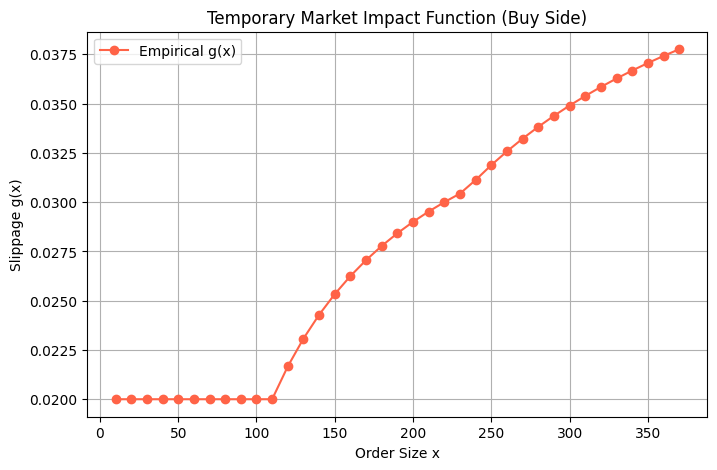

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(order_sizes, slippages, marker='o', color='tomato', label="Empirical g(x)")
plt.title("Temporary Market Impact Function (Buy Side)")
plt.xlabel("Order Size x")
plt.ylabel("Slippage g(x)")
plt.grid(True)
plt.legend()
plt.show()


In [8]:
from numpy.polynomial.polynomial import Polynomial

fit = Polynomial.fit(order_sizes, slippages, deg=2)
coefs = fit.convert().coef
alpha = coefs[1]
beta = coefs[2]

print("Fitted Model: g(x) ≈ {:.5f}x + {:.5f}x²".format(alpha, beta))


Fitted Model: g(x) ≈ 0.00005x + 0.00000x²


In [9]:
# ⚙️ Cell 8: Optimization - Allocate Total Shares Over Time
N = 10  # Number of time intervals (e.g., 10 mins for demo)
S = 300  # Total shares to buy

# Assume the same fitted α and β for each time slot
alpha_vec = np.full(N, alpha)
beta_vec = np.full(N, beta)

# Define optimization variables
x = cp.Variable(N)
cost = cp.sum(cp.multiply(alpha_vec, x) + cp.multiply(beta_vec, cp.square(x)))
constraints = [x >= 0, cp.sum(x) == S]

# Solve the problem
problem = cp.Problem(cp.Minimize(cost), constraints)
problem.solve()

x_opt = x.value.round(2)
print("Optimal Allocation:\n", x_opt)


Optimal Allocation:
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]


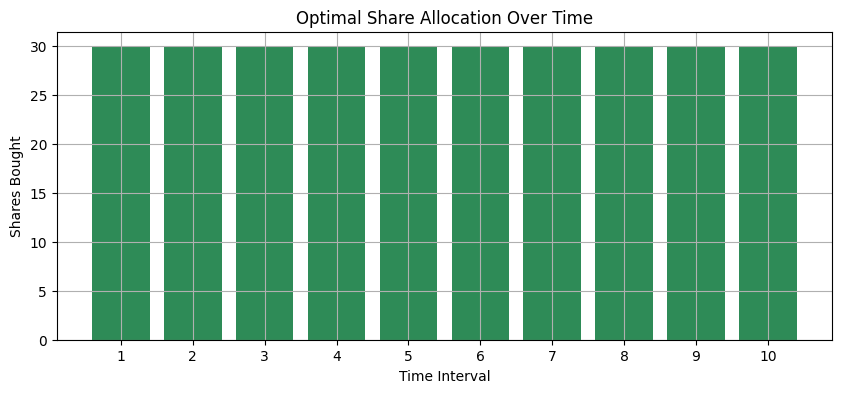

In [12]:
# 📊 Cell 9: Plot Optimal Allocation
plt.figure(figsize=(10, 4))
plt.bar(range(1, N+1), x_opt, color='seagreen')
plt.title("Optimal Share Allocation Over Time")
plt.xlabel("Time Interval")
plt.ylabel("Shares Bought")
plt.xticks(range(1, N+1))
plt.grid(True)
plt.show()


In [13]:
# 📋 Cell 10: Summary Table and Cost
total_cost = np.sum(alpha_vec * x_opt + beta_vec * x_opt**2)

df = pd.DataFrame({
    'Time Interval': np.arange(1, N+1),
    'Shares Bought': x_opt,
    'g(x)': np.round(alpha_vec * x_opt + beta_vec * x_opt**2, 4)
})

print("✅ Total Slippage Cost: {:.4f}".format(total_cost))
df


✅ Total Slippage Cost: 0.0147


,Time Interval,Shares Bought,g(x)
0,1,30.0,0.0015
1,2,30.0,0.0015
2,3,30.0,0.0015
3,4,30.0,0.0015
4,5,30.0,0.0015
5,6,30.0,0.0015
6,7,30.0,0.0015
7,8,30.0,0.0015
8,9,30.0,0.0015
9,10,30.0,0.0015
